**Implementation**

**Decoding Personality Traits Through WhatsApp Chats**

**Importing the required libraries**

In [1]:
!pip install emoji
!pip install wordcloud
import re
import pandas as pd
import numpy as np
import emoji
from collections import Counter
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns



 **Define the File Path & Open and Read the File**

In [2]:
conversation = r"Whatsapp_group_chats_txt_file"

with open(conversation, "r", encoding="utf-8") as file:
    lines = file.readlines()

print(f"Total lines in chat file: {len(lines)}")
print("\nFirst 10 lines from the file:")
for i in range(min(10, len(lines))):
    print(lines[i].strip())


FileNotFoundError: [Errno 2] No such file or directory: 'Whatsapp_group_chats_txt_file'

 **Identification of  whether a line from a WhatsApp chat file starts with a timestamp.** 

In [4]:
import re

def date_time(s):
    pattern = r'^(\d{1,2})/(\d{1,2})/(\d{2,4}), (\d{1,2}):(\d{2}) ?(AM|PM|am|pm)? -'
    return bool(re.match(pattern, s))

# Test on first 10 lines from the chat file
for line in lines[:10]:
    print(f"{line.strip()} → {date_time(line)}")


NameError: name 'lines' is not defined

**Extract structured data (date, time, author, and message) from a single line of a WhatsApp chat file.**

In [6]:
def getMessage(line):
    if " - " not in line:
        return None, None, None, None  # Skip invalid lines

    splitline = line.split(" - ", 1)
    datetime_part = splitline[0]
    
    try:
        date, time = datetime_part.split(", ", 1)
    except ValueError:
        return None, None, None, None  # Skip invalid lines
    
    message_part = splitline[1]
    if ": " in message_part:
        author, message = message_part.split(": ", 1)
    else:
        author, message = None, message_part  # No contact name found
    
    return date, time, author, message


In [8]:
for line in lines[:10]:  
    print(getMessage(line))


NameError: name 'lines' is not defined

**Extracts structured message data from a WhatsApp chat file and stores it in a list. It correctly handles multiline messages, ensuring they are grouped with their respective timestamps and authors.**

In [10]:
data = []
messageBuffer = []
date, time, author = None, None, None

for line in lines:
    line = line.strip()
    if not line:
        continue  # Skip empty lines

    if date_time(line):  # If it's a new message
        if messageBuffer:
            data.append([date, time, author, ' '.join(messageBuffer)])
        messageBuffer.clear()
        date, time, author, message = getMessage(line)
        messageBuffer.append(message)
    else:
        messageBuffer.append(line)  # Append multiline messages

if messageBuffer:
    data.append([date, time, author, ' '.join(messageBuffer)])

print(f"Total messages extracted: {len(data)}")
print(data[:5])  # Show first 5 extracted messages


NameError: name 'lines' is not defined

 **Sentiment of WhatsApp chat messages using NLTK's VADER Sentiment Analysis.**

In [12]:
#Convert Extracted Data into a Pandas DataFrame
df = pd.DataFrame(data, columns=["Date", "Time", "Contact", "Message"])

#Ensure Data is Clean
if df.empty:
    print("No messages extracted. Fix chat parsing first.")
else:
    df['Date'] = pd.to_datetime(df['Date'])
    df.dropna(inplace=True)


# Initialize Sentiment Analyzer
sentiments = SentimentIntensityAnalyzer()

# Apply Sentiment Analysis
df["Positive"] = df["Message"].astype(str).apply(lambda x: sentiments.polarity_scores(x)["pos"])
df["Negative"] = df["Message"].astype(str).apply(lambda x: sentiments.polarity_scores(x)["neg"])
df["Neutral"] = df["Message"].astype(str).apply(lambda x: sentiments.polarity_scores(x)["neu"])

# Display first 5 messages
pd.set_option('display.width', 200)  # Adjust width for better formatting
print(df.head(25).to_string(index=False))



No messages extracted. Fix chat parsing first.
Empty DataFrame
Columns: [Date, Time, Contact, Message, Positive, Negative, Neutral]
Index: []


Keywords:
Positive= ok, pls , good, kindly. god bless you, interested, ok(1),Thanks, good night, clear, school friend,Its okay, true, nice ,idea, Ha(1), talent, yes ,like, thank you(0.7),bro,winners(1),play(0.3),badminton, interested, better, please ,creative , cool, amazing , supremacy, wishes ,lol(1), love ,do not get confused ,lamo, happy ,birthday, important,holiday , share ,urgent ,ha ,special,loved,blessed,ethical,joke,yes,kindly

Negative= exam,password,no,should ,immediately ,mistake ,stress ,wrong ,bomb ,blast, cancel ,tension ,bad, stress ,mistake ,dead, no,outsider , allowed ,lost , chemistry ,spamming,wrong ,postpone, cut,not ,leave ,change ,donate , not eligible

Neutral = marathi typing,links,any information or description ,thanks , nice ,this message was deleted,yup(1),hi (1),quetions?

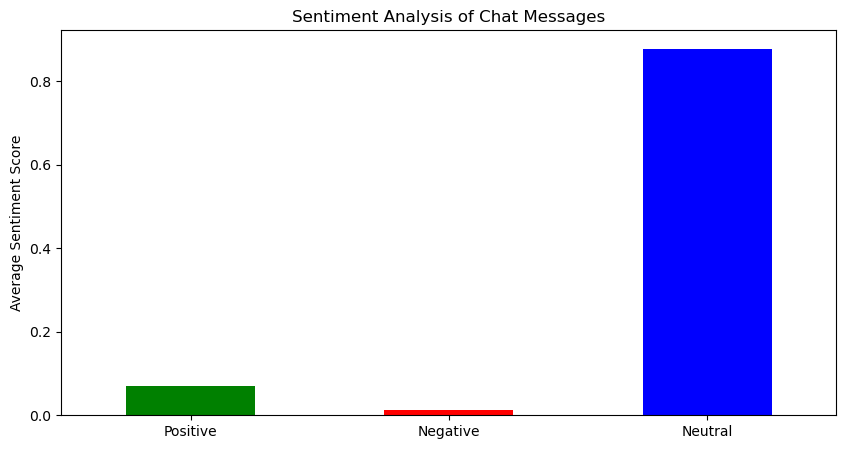

In [21]:
# Sentiment Visualization (Positive, Neutral, Negative Messages)
plt.figure(figsize=(10, 5))
sentiment_counts = df[["Positive", "Negative", "Neutral"]].mean()
sentiment_counts.plot(kind="bar", color=["green", "red", "blue"])
plt.title("Sentiment Analysis of Chat Messages")
plt.ylabel("Average Sentiment Score")
plt.xticks(rotation=0)
plt.show()

**Chat statistics**

In [23]:
# Initialize Data Storage
data = []
messageBuffer = []
date, time, author = None, None, None

# Regex for link detection
link_pattern = r"https?://\S+"

for line in lines:
    line = line.strip()
    if not line or "<Media omitted>" in line:
        continue  # Skip empty lines and media messages

    if re.match(r'^(\d{1,2})/(\d{1,2})/(\d{2,4}), (\d{1,2}):(\d{2}) ?(AM|PM|am|pm)? -', line):  
        if messageBuffer:
            data.append([date, time, author, ' '.join(messageBuffer)])
        messageBuffer.clear()
        date, time, author, message = getMessage(line)
        messageBuffer.append(message)
    else:
        messageBuffer.append(line)

if messageBuffer:
    data.append([date, time, author, ' '.join(messageBuffer)])

# Convert to DataFrame
df = pd.DataFrame(data, columns=["Date", "Time", "Contact", "Message"])

# Chat Statistics
total_messages = len(df)
total_words = df["Message"].dropna().apply(lambda x: len(x.split())).sum()
media_shared = df["Message"].str.contains("<Media omitted>").sum()
links_shared = df["Message"].str.contains(link_pattern, regex=True).sum()
deleted_messages = df["Message"].str.contains("This message was deleted").sum()

# Print Statistics
print(f" Chat Statistics:")
print(f" Total Messages: {total_messages}")
print(f" Total Words: {total_words}")
print(f" Media Shared: {media_shared}")
print(f" Links Shared: {links_shared}")
print(f" Deleted Messages: {deleted_messages}")



 Chat Statistics:
 Total Messages: 2598
 Total Words: 14803
 Media Shared: 0
 Links Shared: 55
 Deleted Messages: 140


**Chat Statistics Per User**

In [14]:
# Convert to DataFrame
df = pd.DataFrame(data, columns=["Date", "Time", "Contact", "Message"])

# Remove NaN values
df.dropna(inplace=True)

# Function to count words in a message
df["Word Count"] = df["Message"].apply(lambda x: len(str(x).split()))
df["Media"] = df["Message"].apply(lambda x: "<Media omitted>" in str(x))
df["Links"] = df["Message"].apply(lambda x: bool(re.search(link_pattern, str(x))))

# Grouping by user
author_stats = df.groupby("Contact").agg(
    Total_Messages=("Message", "count"),
    Average_Words_per_Message=("Word Count", "mean"),
    Total_Media_Messages=("Media", "sum"),
    Total_Links_Sent=("Links", "sum")
).reset_index()

# Display results
print(" Chat Statistics Per User:")
print(author_stats)


 Chat Statistics Per User:
Empty DataFrame
Columns: [Contact, Total_Messages, Average_Words_per_Message, Total_Media_Messages, Total_Links_Sent]
Index: []


**Big Five Personality Traits using message statistics, sentiment analysis, and linguistic features.**

Groups messages by user (Contact) and calculates:
📩 Total Messages Sent.
📖 Total Words Used → Sum of words in all messages.
😊 Positive Sentiment Score → Average positivity score of messages.
😠 Negative Sentiment Score → Average negativity score of messages.
😂 Emojis Used → Total emoji count.
🔗 Links Sent → Number of messages containing URLs (http).
🖼 Media Sent → Number of times media was shared (<Media omitted>).
📏 Average Message Length → Average number of characters per message.

**Each Big Five trait is estimated using chat behavior:**

Openness → Longer messages & positivity indicate curiosity and creativity.
Neuroticism → Higher negativity suggests emotional instability.
Agreeableness → Higher positivity indicates friendliness.
Extraversion → More messages & emoji usage suggest social engagement.
Conscientiousness → More links & media indicate structured communication.

In [16]:
# Ensure NLTK Vader Lexicon is available
nltk.download("vader_lexicon")
sentiments = SentimentIntensityAnalyzer()



# Step 1: Function to extract personality traits
def analyze_personality(df):
    user_stats = df.groupby("Contact").agg(
        Total_Messages=("Message", "count"),
        Total_Words=("Message", lambda x: sum(len(msg.split()) for msg in x if isinstance(msg, str))),
        Positive_Sentiment=("Message", lambda x: np.mean([sentiments.polarity_scores(str(msg))["pos"] for msg in x])),
        Negative_Sentiment=("Message", lambda x: np.mean([sentiments.polarity_scores(str(msg))["neg"] for msg in x])),
        Emojis=("Message", lambda x: sum([len([char for char in msg if char in emoji.EMOJI_DATA]) for msg in x])),
        Links_Sent=("Message", lambda x: sum([1 for msg in x if "http" in str(msg)])),
        Media_Sent=("Message", lambda x: sum([1 for msg in x if "<Media omitted>" in str(msg)])),
        Avg_Message_Length=("Message", lambda x: np.mean([len(str(msg)) for msg in x])),
    )

    # Step 2: Map statistics to Big Five Personality Traits
    user_stats["Openness"] = user_stats["Avg_Message_Length"] + (user_stats["Positive_Sentiment"] * 5)
    user_stats["Neuroticism"] = user_stats["Negative_Sentiment"] * 10
    user_stats["Agreeableness"] = user_stats["Positive_Sentiment"] * 10
    user_stats["Extraversion"] = user_stats["Total_Messages"] + user_stats["Emojis"]
    user_stats["Conscientiousness"] = user_stats["Links_Sent"] + user_stats["Media_Sent"] * 2

    # Normalize scores (between 0 and 1)
    for trait in ["Openness", "Neuroticism", "Agreeableness", "Extraversion", "Conscientiousness"]:
        user_stats[trait] = (user_stats[trait] - user_stats[trait].min()) / (user_stats[trait].max() - user_stats[trait].min())

    return user_stats.reset_index()

# Step 3: Run analysis
personality_df = analyze_personality(df)

# Display the results
pd.set_option("display.max_rows", None)
print(personality_df[["Contact", "Openness", "Neuroticism", "Agreeableness", "Extraversion", "Conscientiousness"]])


Empty DataFrame
Columns: [Contact, Openness, Neuroticism, Agreeableness, Extraversion, Conscientiousness]
Index: []


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\arpit\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


TypeError: Column 'Openness' has dtype object, cannot use method 'nlargest' with this dtype

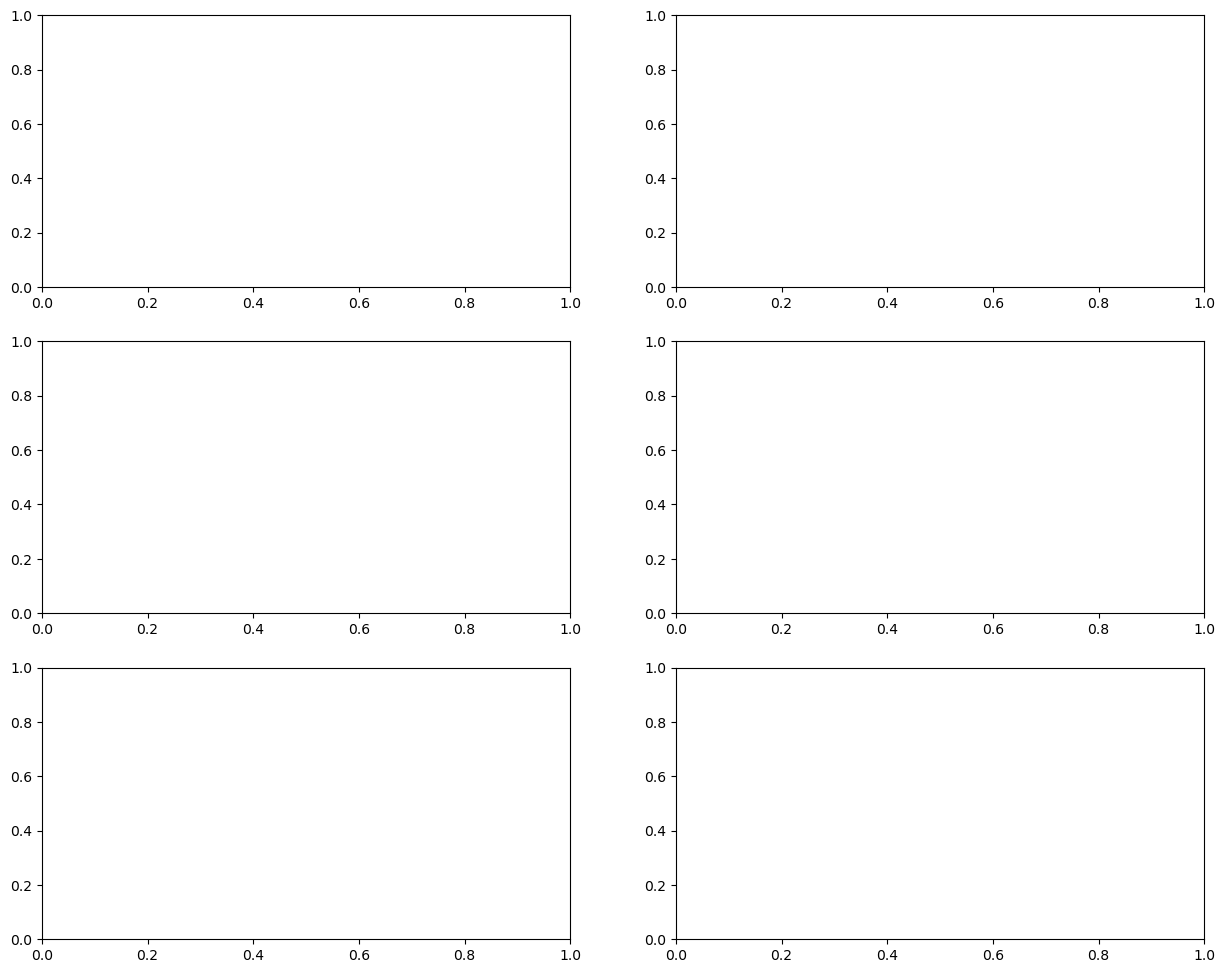

In [18]:
# Ensure personality_df is defined
if 'personality_df' not in locals():
    personality_df = analyze_personality(df)

# Traits to visualize
traits = ["Openness", "Neuroticism", "Agreeableness", "Extraversion", "Conscientiousness"]

# Set up subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
axes = axes.flatten()

# Loop through each trait and plot the top 10 users
for i, trait in enumerate(traits):
    top_users = personality_df.nlargest(10, trait)
    sns.barplot(x=top_users[trait], y=top_users["Contact"], ax=axes[i], palette="viridis")
    axes[i].set_title(f"Top 10 Users - {trait}")
    axes[i].set_xlabel("Score")
    axes[i].set_ylabel("Contact")

# Remove extra subplot if needed
fig.delaxes(axes[-1])

# Adjust layout
plt.tight_layout()
plt.show()


In [20]:
# Get top 5 most active users
top_users = personality_df.nlargest(5, "Total_Messages")

# Set color palette
sns.set_palette("coolwarm")

# 1. Bar Plot for Personality Traits
plt.figure(figsize=(12, 6))
traits = ["Openness", "Neuroticism", "Agreeableness", "Extraversion", "Conscientiousness"]
top_users.set_index("Contact")[traits].plot(kind="bar", figsize=(12, 6), colormap="coolwarm", edgecolor="black")
plt.title("Big Five Personality Traits of Top 5 Active Users")
plt.ylabel("Normalized Score (0-1)")
plt.xlabel("User")
plt.xticks(rotation=45)
plt.legend(title="Traits")
plt.show()

# 2. Radar Chart for Personality
def plot_radar_chart(df):
    labels = np.array(traits)
    num_vars = len(labels)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Close the loop

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    for i, row in df.iterrows():
        values = row[traits].values.flatten().tolist()
        values += values[:1]  # Close the loop
        ax.plot(angles, values, linewidth=2, linestyle="solid", label=row["Contact"])
        ax.fill(angles, values, alpha=0.2)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    plt.title("Radar Chart of Personality Traits")
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
    plt.show()

plot_radar_chart(top_users)


TypeError: no numeric data to plot

<Figure size 1200x600 with 0 Axes>

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\arpit\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\arpit\AppData\Local\Temp\ipykernel_7924\1609376398.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Hour'] = pd.to_datetime(df['Time']).dt.hour


Accuracy: 0.9841584158415841
                   precision    recall  f1-score   support

    Agreeableness       1.00      1.00      1.00         9
Conscientiousness       1.00      1.00      1.00       405
     Extraversion       0.92      0.69      0.79        16
      Neuroticism       0.00      0.00      0.00         2
         Openness       0.94      0.99      0.96        73

         accuracy                           0.98       505
        macro avg       0.77      0.73      0.75       505
     weighted avg       0.98      0.98      0.98       505



C:\Users\arpit\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\arpit\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\arpit\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cross-Validation Accuracy Scores: [0.98811881 0.98613861 0.98811881 0.98214286 0.99007937]
Mean CV Accuracy: 0.9869196919691969


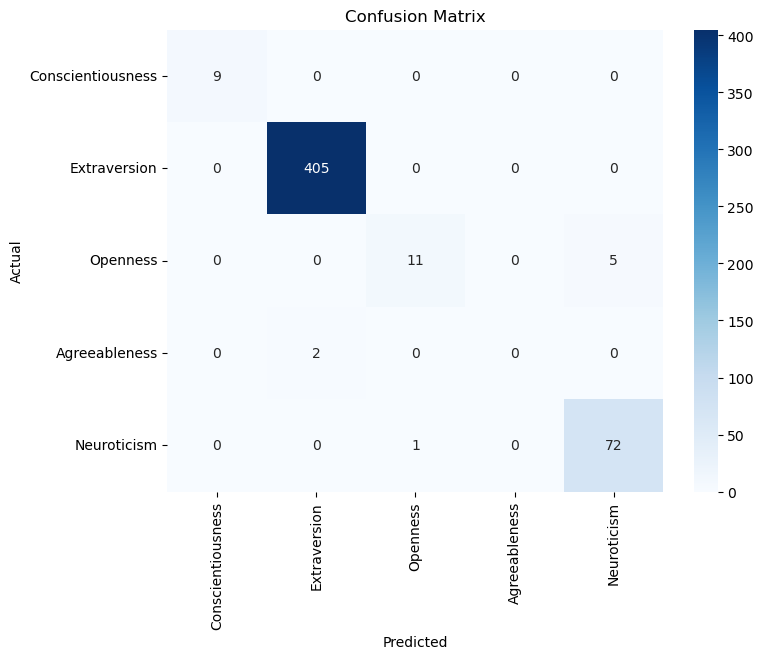

In [31]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from nltk.sentiment import SentimentIntensityAnalyzer


# Sentiment Analysis
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
df["Sentiment_Score"] = df["Message"].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])

# Feature Engineering
df['Word_Count'] = df['Message'].apply(lambda x: len(str(x).split()))
df['Emoji_Count'] = df['Message'].apply(lambda x: len([c for c in x if c in emoji.EMOJI_DATA]))
df['Message_Length'] = df['Message'].apply(lambda x: len(str(x)))
df['Hour'] = pd.to_datetime(df['Time']).dt.hour

# Assign personality labels based on heuristic rules
def assign_personality(row):
    if row['Sentiment_Score'] > 0.3 and row['Word_Count'] > 10:
        return "Extraversion"
    elif row['Sentiment_Score'] < -0.3 and row['Word_Count'] < 5:
        return "Neuroticism"
    elif row['Emoji_Count'] > 2:
        return "Agreeableness"
    elif row['Message_Length'] > 50:
        return "Openness"
    else:
        return "Conscientiousness"

df['Personality'] = df.apply(assign_personality, axis=1)

# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=500)
X_text = vectorizer.fit_transform(df['Message'].astype(str)).toarray()
X_features = df[['Word_Count', 'Emoji_Count', 'Message_Length', 'Sentiment_Score', 'Hour']]
X = np.hstack((X_text, X_features))
y = df['Personality']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Model Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Cross-Validation Score (to check stability)
cv_scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
labels = df['Personality'].unique()
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



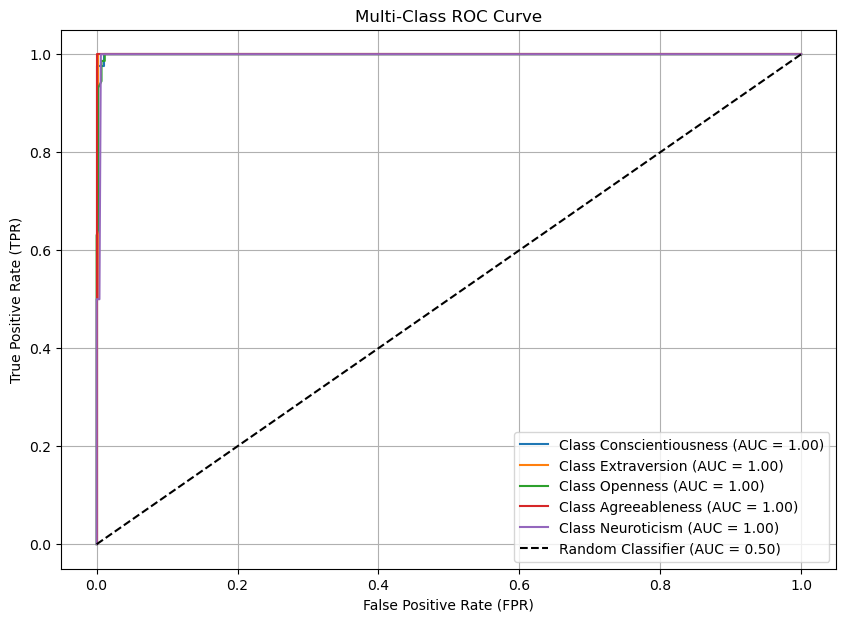

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Binarize the labels for multi-class ROC-AUC evaluation
y_binarized = label_binarize(y, classes=df['Personality'].unique())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_binarized, test_size=0.2, random_state=42)

# Train the One-vs-Rest (OvR) model
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
clf.fit(X_train, y_train)

# Predict probabilities
y_score = clf.predict_proba(X_test)

# Compute ROC curve and AUC for each class
n_classes = y_binarized.shape[1]
plt.figure(figsize=(10, 7))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_score[:, i])
    auc_score = roc_auc_score(y_test[:, i], y_score[:, i])
    plt.plot(fpr, tpr, label=f"Class {df['Personality'].unique()[i]} (AUC = {auc_score:.2f})")

# Plot random baseline (diagonal line)
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier (AUC = 0.50)")

# Plot styling
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Multi-Class ROC Curve")
plt.legend()
plt.grid()
plt.show()


**Graphical Insights from WhatsApp Group Chats**

IndexError: index 0 is out of bounds for axis 0 with size 0

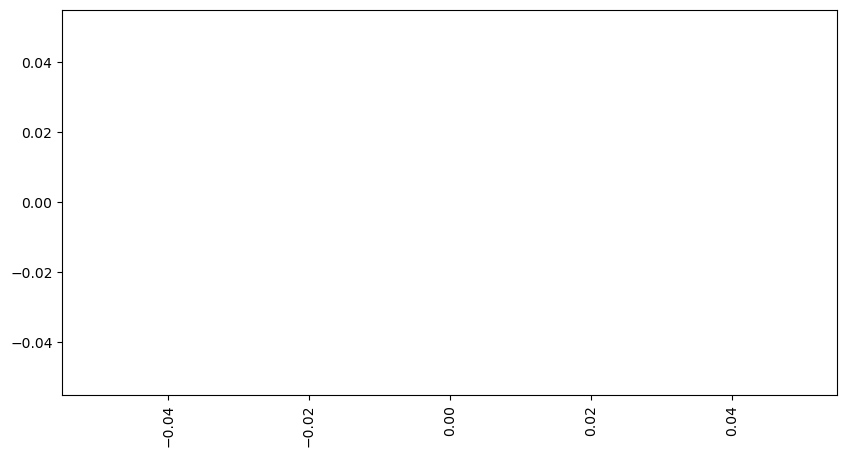

In [22]:
# Load the chat data from the DataFrame
df["Date"] = pd.to_datetime(df["Date"])  # Ensure Date is in datetime format

# 1. Most Active Users (Top Message Senders)
plt.figure(figsize=(10, 5))
df["Contact"].value_counts().head(10).plot(kind="bar", color="green")
plt.title("Top 10 Most Active Users")
plt.xlabel("Users")
plt.ylabel("Number of Messages")
plt.xticks(rotation=45)
plt.show()

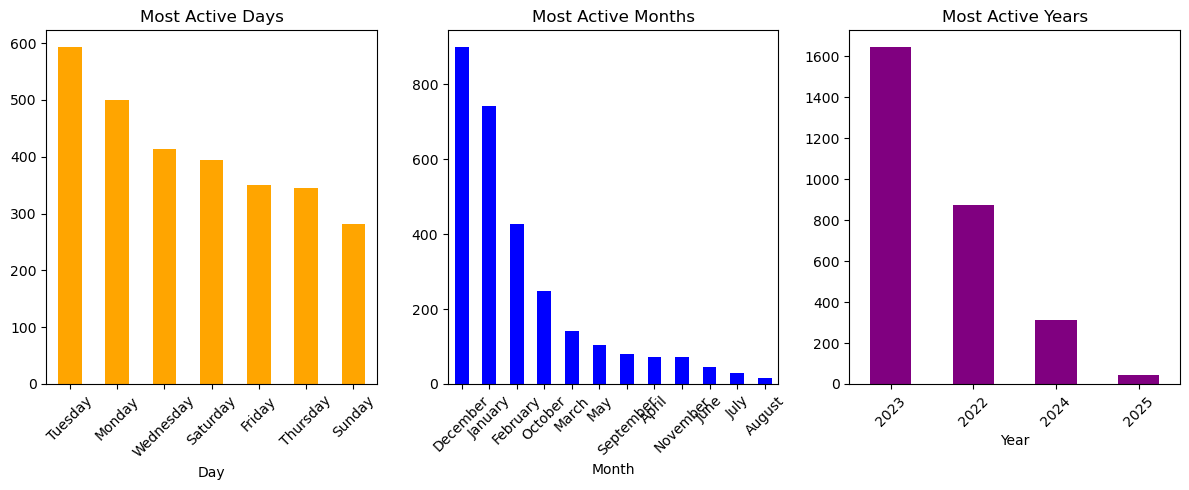

In [96]:
# 5. Most Active Day, Month, Year
plt.figure(figsize=(12, 5))
df["Day"] = df["Date"].dt.day_name()
df["Month"] = df["Date"].dt.month_name()
df["Year"] = df["Date"].dt.year

plt.subplot(1, 3, 1)
df["Day"].value_counts().plot(kind="bar", color="orange")
plt.title("Most Active Days")
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
df["Month"].value_counts().plot(kind="bar", color="blue")
plt.title("Most Active Months")
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
df["Year"].value_counts().plot(kind="bar", color="purple")
plt.title("Most Active Years")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


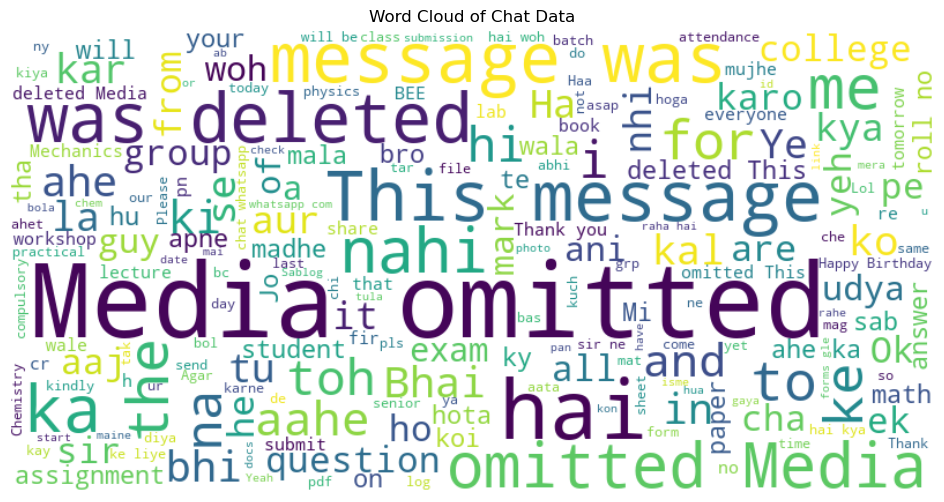

In [98]:
# Word Cloud of Chat Dataset
text = " ".join(df["Message"].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis", stopwords=set(["https", "drive", "google"])).generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Chat Data")
plt.show()

<Figure size 1200x500 with 0 Axes>

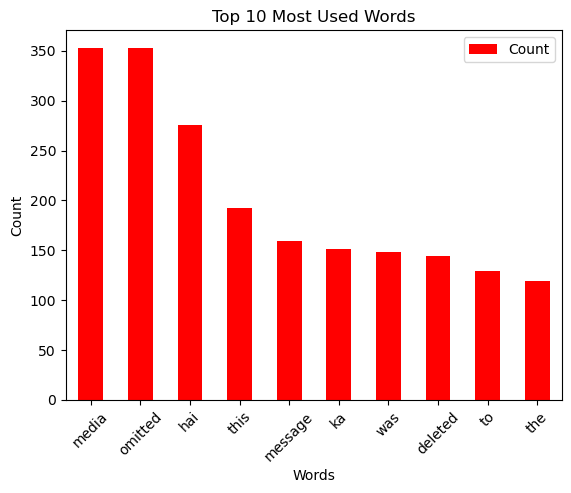

In [100]:
# Most Used Words
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove links
    text = re.sub(r"[^\w\s]", "", text)  # Remove special characters
    text = text.lower()
    return text

df["Cleaned_Message"] = df["Message"].astype(str).apply(clean_text)
all_words = " ".join(df["Cleaned_Message"]).split()
word_counts = Counter(all_words)

plt.figure(figsize=(12, 5))
pd.DataFrame(word_counts.most_common(10), columns=["Word", "Count"]).set_index("Word").plot(kind="bar", color="red")
plt.title("Top 10 Most Used Words")
plt.xlabel("Words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

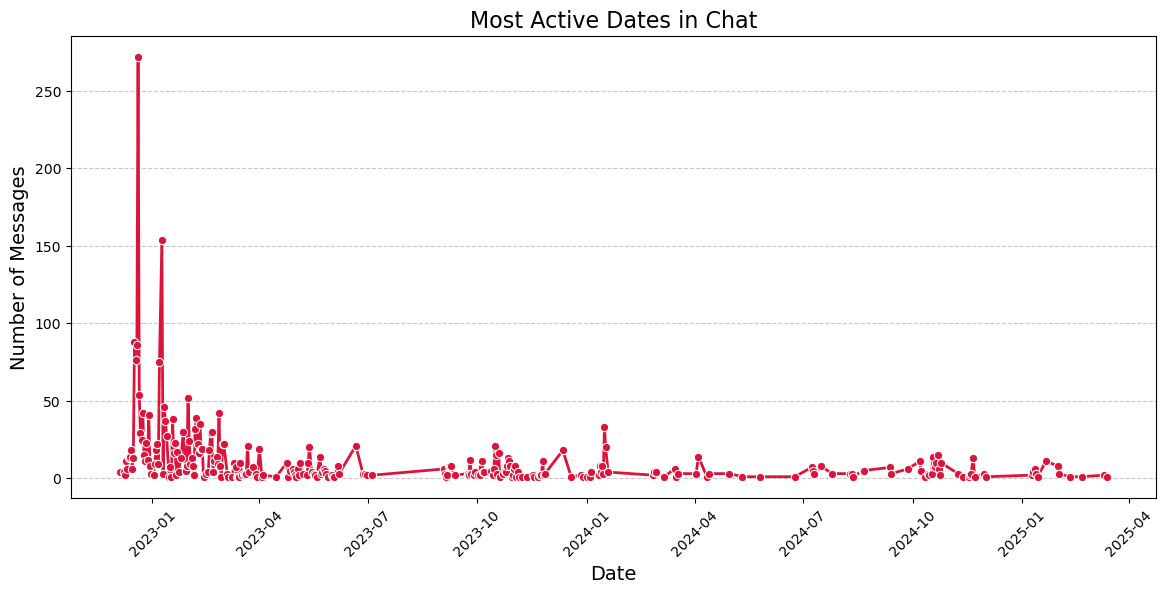

In [102]:
# Convert date to proper datetime format
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)

# Count messages per date
daily_activity = df["Date"].value_counts().sort_index()

# 📊 Plot Most Active Dates
plt.figure(figsize=(14, 6))
sns.lineplot(x=daily_activity.index, y=daily_activity.values, marker="o", linewidth=2, color="crimson")

plt.xlabel("Date", fontsize=14)
plt.ylabel("Number of Messages", fontsize=14)
plt.title("Most Active Dates in Chat", fontsize=16)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [24]:
import pandas as pd
import nltk
from collections import Counter
from nltk.corpus import stopwords
import string

# Download stopwords if not already downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to clean and tokenize messages
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    words = text.split()  # Tokenize words
    words = [word for word in words if word not in stop_words and len(word) > 2]  # Remove stopwords and short words
    return words

# Apply preprocessing to messages
df['Tokenized_Message'] = df['Message'].astype(str).apply(preprocess_text)

# Find the most used word by each user
user_word_counts = {}
for user, messages in df.groupby("Contact")["Tokenized_Message"]:
    all_words = [word for message in messages for word in message]  # Flatten list of words
    if all_words:  # Ensure there are words before proceeding
        most_common_word = Counter(all_words).most_common(1)[0][0]  # Get the most used word
        user_word_counts[user] = most_common_word
    else:
        user_word_counts[user] = "No words found"  # If no words are available

# Convert dictionary to DataFrame
word_df = pd.DataFrame(user_word_counts.items(), columns=["User", "Most Used Word"])

# Display the table
print(word_df)


Empty DataFrame
Columns: [User, Most Used Word]
Index: []


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arpit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


C:\Users\arpit\AppData\Local\Temp\ipykernel_7924\2109204556.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=daywise_activity.index, y=daywise_activity.values, palette="coolwarm")


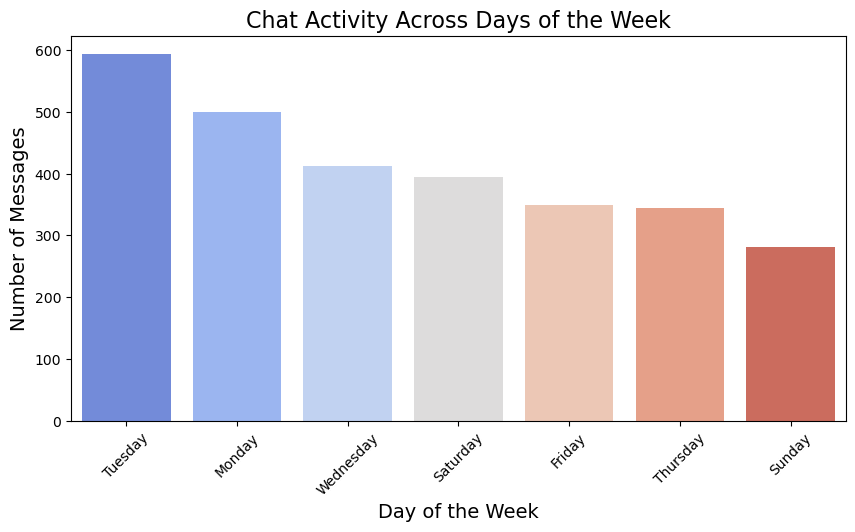

In [106]:
import seaborn as sns

# Extract Day of the Week
df["Day"] = df["Date"].dt.day_name()

# Count Messages Per Day
daywise_activity = df["Day"].value_counts()

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=daywise_activity.index, y=daywise_activity.values, palette="coolwarm")

plt.xlabel("Day of the Week", fontsize=14)
plt.ylabel("Number of Messages", fontsize=14)
plt.title("Chat Activity Across Days of the Week", fontsize=16)
plt.xticks(rotation=45)
plt.show()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\arpit\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


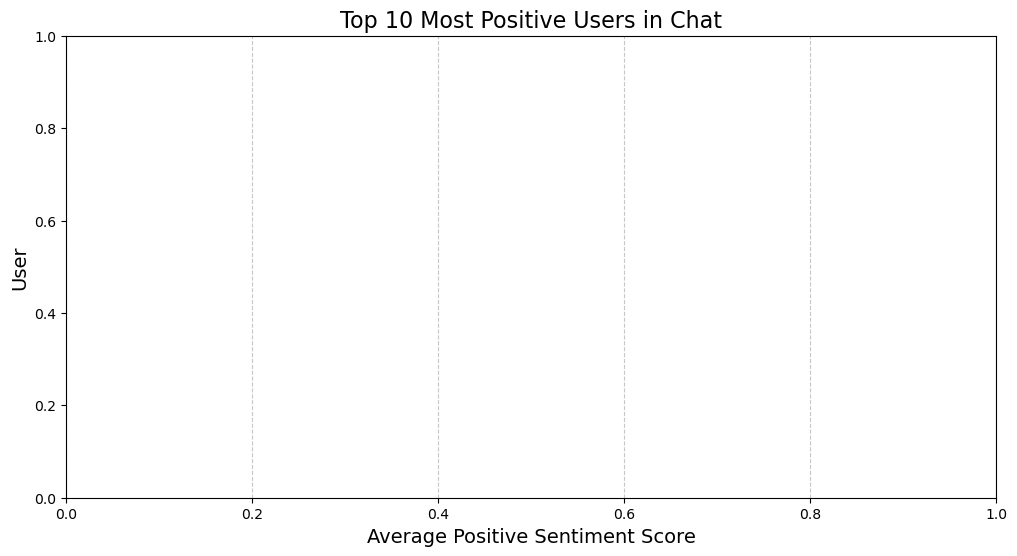

In [26]:
# Download VADER sentiment lexicon
nltk.download("vader_lexicon")

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Apply Sentiment Analysis
df["Positive"] = df["Message"].apply(lambda x: sia.polarity_scores(str(x))["pos"])
df["Negative"] = df["Message"].apply(lambda x: sia.polarity_scores(str(x))["neg"])
df["Neutral"] = df["Message"].apply(lambda x: sia.polarity_scores(str(x))["neu"])

# Group by user and calculate average positive sentiment
positive_users = df.groupby("Contact")["Positive"].mean().sort_values(ascending=False).head(10)

# Plot the most positive users
plt.figure(figsize=(12, 6))
sns.barplot(x=positive_users.values, y=positive_users.index, palette="Greens_r")

plt.xlabel("Average Positive Sentiment Score", fontsize=14)
plt.ylabel("User", fontsize=14)
plt.title("Top 10 Most Positive Users in Chat", fontsize=16)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

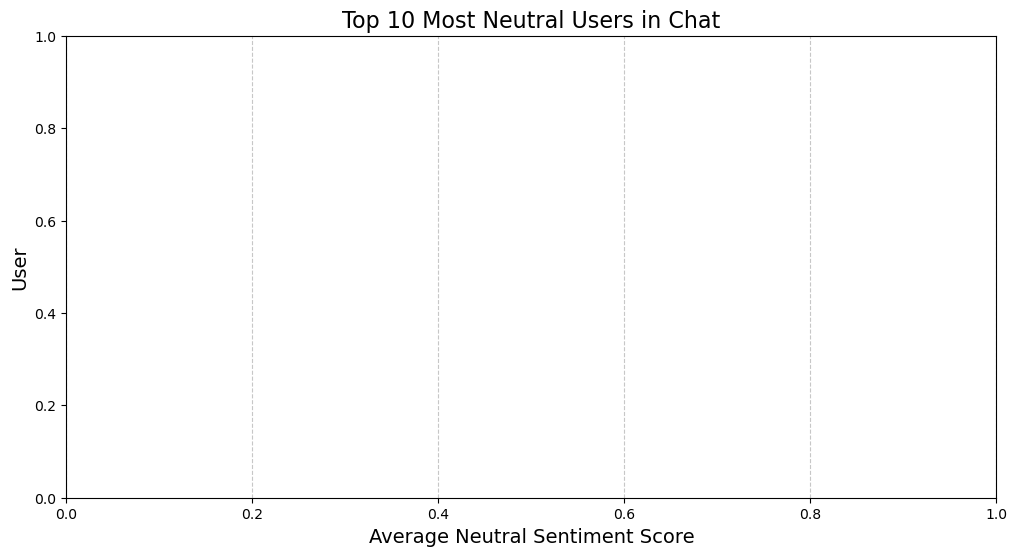

In [28]:
# Group by user and calculate average neutral sentiment
neutral_users = df.groupby("Contact")["Neutral"].mean().sort_values(ascending=False).head(10)

# Plot the most neutral users
plt.figure(figsize=(12, 6))
sns.barplot(x=neutral_users.values, y=neutral_users.index, palette="Blues_r")

plt.xlabel("Average Neutral Sentiment Score", fontsize=14)
plt.ylabel("User", fontsize=14)
plt.title("Top 10 Most Neutral Users in Chat", fontsize=16)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

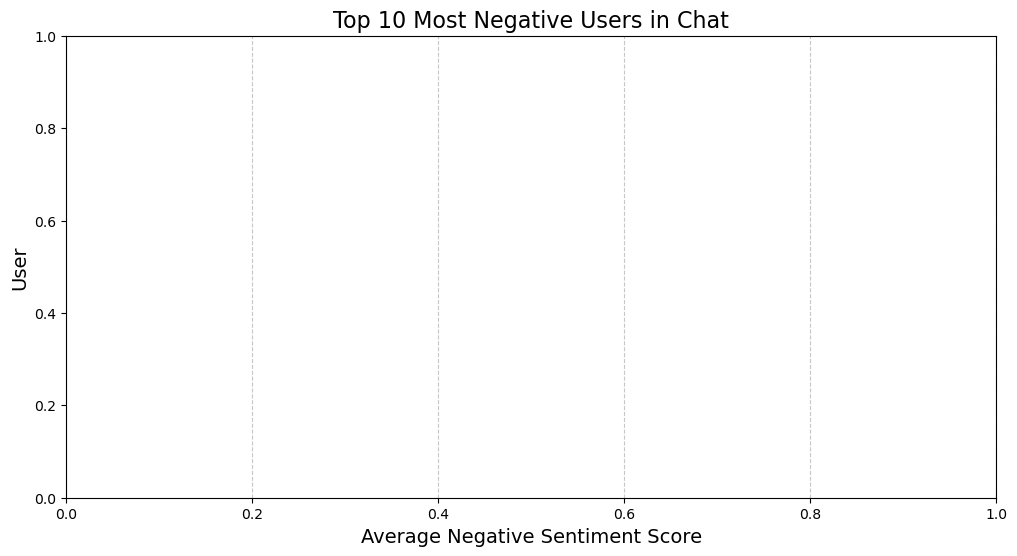

In [30]:
# Group by user and calculate average negative sentiment
negative_users = df.groupby("Contact")["Negative"].mean().sort_values(ascending=False).head(10)

# Plot the most negative users
plt.figure(figsize=(12, 6))
sns.barplot(x=negative_users.values, y=negative_users.index, palette="Reds_r")

plt.xlabel("Average Negative Sentiment Score", fontsize=14)
plt.ylabel("User", fontsize=14)
plt.title("Top 10 Most Negative Users in Chat", fontsize=16)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()